# ÍNDICE  

- [Objetivos](#Objetivos)
- [Preparación de la información](#Preparación-de-la-información)
    - [Carga de la información](#Carga-de-la-información)
    - [Creación del marco de datos](#Creación-del-marco-de-datos)
    - [Completitud del dataset](#Completitud-del-dataset)
- [Exploración de datos](#Exploración-de-datos)
    - [Curtosis y simetría](#Curtosis-y-simetría)
    - [Varianza](#Varianza) 
    - [Análisis de correlación](#Análisis-de-correlación)
- [Selección del contaminante](#Selección-del-contaminante)
- [Estacionariedad](#Estacionariedad)
- [Construcción del modelo](#Construcción-del-modelo)
    - [Suavizado Exponencial Simple](#Suavizado-Exponencial-Simple)
    - [Predictor Ingenuo](#Predictor-Ingenuo)
    - [SARIMA](#SARIMA)
    - [Regresión de Bosques Aleatorios](#Regresión-de-Bosques-Aleatorios)
    - [Regresión de Soporte Vectorial](#Regresión-de-Soporte-Vectorial)
    - [Regresión de Gradiente Ascendente](#Regresión-de-Gradiente-Ascendente)
    - [Ejemplo de Predicción SARIMA (0,1,2)(1,0,1)](#Ejemplo-de-Predicción-SARIMA-(0,1,2)-(1,0,1))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from functools import reduce # To merge multiple dataframes 
import missingno as msno #To explore missing data

from sklearn.preprocessing import PowerTransformer

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Objetivos
[ÍNDICE](#ÍNDICE)

•	Preparar los datos recolectados de la plataforma de la Secretaria de Ambiente del Distrito Metropolitano de Quito y discernir entre conjuntos de datos disponibles a partir de su relevancia, completitud, consistencia y confiabilidad mediante el análisis exploratorio de datos para identificar características de las series y llevar a cabo la selección correcta de parámetros. 

• Realizar una comparativa de métodos utilizados, mediante el análisis de métricas empleadas en la evaluación de precisión y desempeño, para evaluar el desempeño del modelo ajustado frente al comportamiento de los datos.

## Preparación de la información 
[ÍNDICE](#ÍNDICE)

### Carga de la información
[ÍNDICE](#ÍNDICE)



In [2]:
# Monoxido de carbono
CO = pd.read_excel('CO.xlsx') #Leer datos
CO = CO.loc[1:,:] #Seleccionar los datos 

#Dioxido de nitrogeno
NO2 = pd.read_excel('NO2.xlsx')
NO2 = NO2.loc[1:,:]

#Ozono troposferico
O3 = pd.read_excel('O3.xlsx')
O3 = O3.loc[1:,:]

#Material particulado 2.5
PM25 = pd.read_excel('PM2.5.xlsx')
PM25 = PM25.loc[1:,:]

#Material particulado 10
PM10 = pd.read_excel('PM10.xlsx')
PM10 = PM10.loc[1:,:]

# Dioxido de azufre
SO2 = pd.read_excel('SO2.xlsx')
SO2 = SO2.loc[1:,:]


### Creación del marco de datos
[ÍNDICE](#ÍNDICE)

* Renombrando columna índice para trabajar con series de tiempo

In [3]:
CO.rename(columns={'Unnamed: 0':'date'}, inplace=True)
NO2.rename(columns={'Unnamed: 0':'date'}, inplace=True)
O3.rename(columns={'Unnamed: 0':'date'}, inplace=True)
PM25.rename(columns={'Unnamed: 0':'date'}, inplace=True)
PM10.rename(columns={'Unnamed: 0':'date'}, inplace=True)
SO2.rename(columns={'Unnamed: 0':'date'}, inplace=True)

* La primera columna es transformada al tipo de dato fecha (date data type)

In [4]:
CO.date = pd.to_datetime(CO.date)
NO2.date = pd.to_datetime(NO2.date)
O3.date = pd.to_datetime(O3.date)
PM25.date = pd.to_datetime(PM25.date)
PM10.date = pd.to_datetime(PM10.date)
SO2.date = pd.to_datetime(SO2.date)

* Se configura la columna "date" como índice

In [5]:
CO.set_index('date', inplace = True)
NO2.set_index('date', inplace = True)
O3.set_index('date', inplace = True)
PM25.set_index('date', inplace = True)
PM10.set_index('date', inplace = True)
SO2.set_index('date', inplace = True)

* Union de los datos para formar el marco de datos

In [6]:
CO_NO2 = CO.merge(NO2, how='outer',on = 'date', suffixes=('_CO', '_NO2')) #Unir los datos

O3_PM25 = O3.merge(PM25,how='outer', on = 'date', suffixes=('_O3', '_PM25'))

SO2_PM10 = SO2.merge(PM10, how='outer',on= 'date', suffixes=('_SO2', '_PM10'))

CO_NO2_SO2_PM10 = CO_NO2.merge(SO2_PM10, how='outer', on = 'date')

CO_NO2_SO2_PM10_O3_PM25= CO_NO2_SO2_PM10.merge(O3_PM25, how='outer', on= 'date')

df = CO_NO2_SO2_PM10_O3_PM25

In [7]:
type(df)

pandas.core.frame.DataFrame

### Completitud del dataset

[ÍNDICE](#ÍNDICE)

In [8]:
df.columns

Index(['BELISARIO_CO', 'CARAPUNGO_CO', 'CENTRO_CO', 'COTOCOLLAO_CO',
       'EL CAMAL_CO', 'GUAMANI_CO', 'LOS CHILLOS_CO', 'TUMBACO_CO',
       'CONDADO_CO', 'TURUBAMBA_CO', 'CHILLOGALLO_CO', 'BELISARIO_NO2',
       'CARAPUNGO_NO2', 'CENTRO_NO2', 'COTOCOLLAO_NO2', 'EL CAMAL_NO2',
       'GUAMANI_NO2', 'LOS CHILLOS_NO2', 'TUMBACO_NO2', 'CONDADO_NO2',
       'TURUBAMBA_NO2', 'CHILLOGALLO_NO2', 'BELISARIO', 'CARAPUNGO_SO2',
       'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI_SO2', 'LOS CHILLOS',
       'TUMBACO_SO2', 'CONDADO', 'TURUBAMBA', 'CHILLOGALLO', 'Unnamed: 12',
       'Unnamed: 13', 'CARAPUNGO_PM10', 'SAN ANTONIO', 'GUAMANI_PM10',
       'TUMBACO_PM10', 'BELISARIO_O3', 'CARAPUNGO_O3', 'CENTRO_O3',
       'COTOCOLLAO_O3', 'EL CAMAL_O3', 'GUAMANI_O3', 'LOS CHILLOS_O3',
       'SAN ANTONIO_O3', 'TUMBACO_O3', 'CONDADO_O3', 'TURUBAMBA_O3',
       'CHILLOGALLO_O3', 'BELISARIO_PM25', 'CARAPUNGO_PM25', 'CENTRO_PM25',
       'COTOCOLLAO_PM25', 'EL CAMAL_PM25', 'GUAMANI_PM25', 'LOS CHILLOS

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151200 entries, 2004-01-01 00:00:00 to 2021-03-31 23:00:00
Data columns (total 63 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BELISARIO_CO      147575 non-null  object 
 1   CARAPUNGO_CO      137624 non-null  object 
 2   CENTRO_CO         144712 non-null  object 
 3   COTOCOLLAO_CO     137586 non-null  object 
 4   EL CAMAL_CO       129052 non-null  object 
 5   GUAMANI_CO        136952 non-null  object 
 6   LOS CHILLOS_CO    60902 non-null   object 
 7   TUMBACO_CO        14654 non-null   object 
 8   CONDADO_CO        9702 non-null    object 
 9   TURUBAMBA_CO      9869 non-null    object 
 10  CHILLOGALLO_CO    0 non-null       object 
 11  BELISARIO_NO2     146556 non-null  object 
 12  CARAPUNGO_NO2     137021 non-null  object 
 13  CENTRO_NO2        145478 non-null  object 
 14  COTOCOLLAO_NO2    137569 non-null  object 
 15  EL CAMAL_NO2      127754 non-null 

<AxesSubplot:>

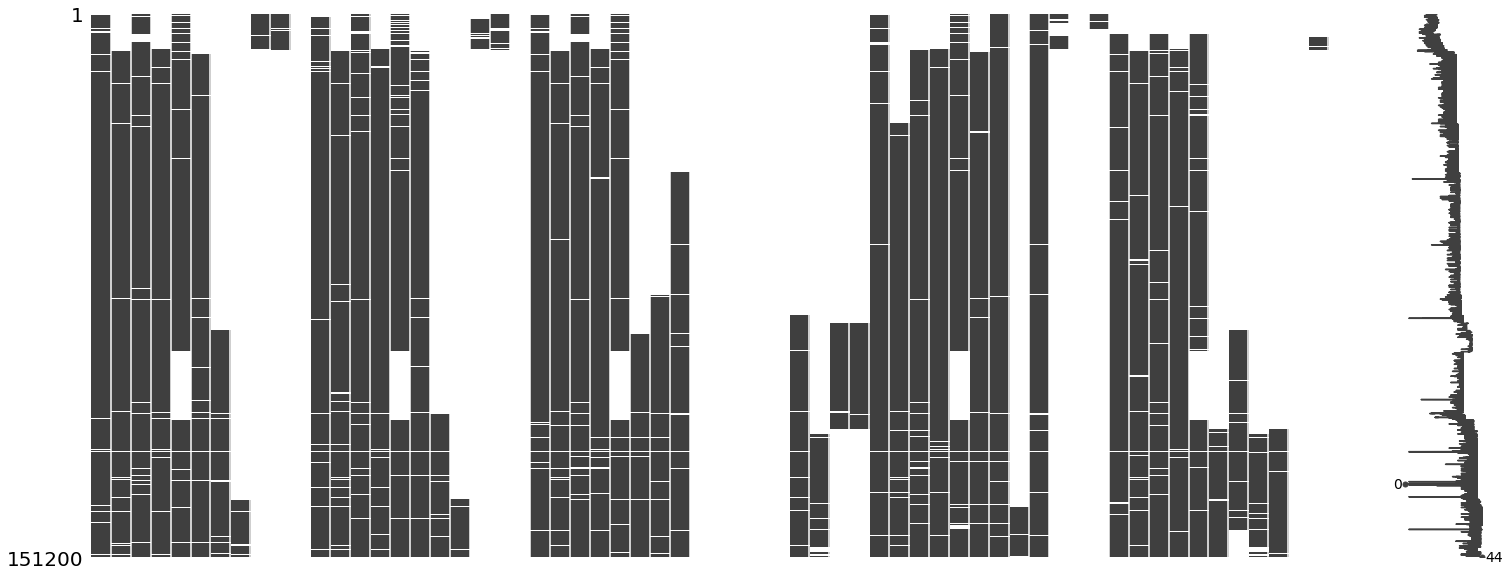

In [10]:
msno.matrix(df)

Función para convertir el tipo de dato a numérico

In [11]:
def a_numerico(df):
    for i in df.columns:
        df[i] = pd.to_numeric(df[i], errors = 'coerce')


In [12]:
a_numerico(df)

Las columnas son desechadas porque tienen demasiados datos faltantes

In [13]:
COLUMNAS_DESECHAR = ['TUMBACO_CO','CONDADO_CO', 'TURUBAMBA_CO', 'CHILLOGALLO_CO','TUMBACO_NO2', 'CONDADO_NO2',
                    'TURUBAMBA_NO2', 'CHILLOGALLO_NO2', 'CONDADO', 'TURUBAMBA', 'CHILLOGALLO', 'SAN ANTONIO_O3',
                     'GUAMANI_PM10','TUMBACO_PM10','CONDADO_O3', 'TURUBAMBA_O3', 'CHILLOGALLO_O3','CONDADO_PM25',
                     'TURUBAMBA_PM25','CHILLOGALLO_PM25',
                    'EL CAMAL_CO','LOS CHILLOS_CO','EL CAMAL_NO2','LOS CHILLOS_NO2','EL CAMAL','GUAMANI_SO2','LOS CHILLOS',
                    'TUMBACO_SO2','CARAPUNGO_PM10','SAN ANTONIO','EL CAMAL_O3','EL CAMAL_PM25','GUAMANI_PM25','LOS CHILLOS_PM25',
                    'SAN ANTONIO_PM25','TUMBACO_PM25','Unnamed: 12','Unnamed: 13']

In [14]:
df.drop(COLUMNAS_DESECHAR, inplace=True, axis=1)

In [15]:
df.columns

Index(['BELISARIO_CO', 'CARAPUNGO_CO', 'CENTRO_CO', 'COTOCOLLAO_CO',
       'GUAMANI_CO', 'BELISARIO_NO2', 'CARAPUNGO_NO2', 'CENTRO_NO2',
       'COTOCOLLAO_NO2', 'GUAMANI_NO2', 'BELISARIO', 'CARAPUNGO_SO2', 'CENTRO',
       'COTOCOLLAO', 'BELISARIO_O3', 'CARAPUNGO_O3', 'CENTRO_O3',
       'COTOCOLLAO_O3', 'GUAMANI_O3', 'LOS CHILLOS_O3', 'TUMBACO_O3',
       'BELISARIO_PM25', 'CARAPUNGO_PM25', 'CENTRO_PM25', 'COTOCOLLAO_PM25'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151200 entries, 2004-01-01 00:00:00 to 2021-03-31 23:00:00
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BELISARIO_CO     144933 non-null  float64
 1   CARAPUNGO_CO     134686 non-null  float64
 2   CENTRO_CO        142207 non-null  float64
 3   COTOCOLLAO_CO    134675 non-null  float64
 4   GUAMANI_CO       134382 non-null  float64
 5   BELISARIO_NO2    144732 non-null  float64
 6   CARAPUNGO_NO2    135190 non-null  float64
 7   CENTRO_NO2       143739 non-null  float64
 8   COTOCOLLAO_NO2   135685 non-null  float64
 9   GUAMANI_NO2      135051 non-null  float64
 10  BELISARIO        144545 non-null  float64
 11  CARAPUNGO_SO2    135264 non-null  float64
 12  CENTRO           142543 non-null  float64
 13  COTOCOLLAO       135030 non-null  float64
 14  BELISARIO_O3     144460 non-null  float64
 15  CARAPUNGO_O3     115715 non-null  float64
 16  CENT

In [17]:
df.rename(columns={'BELISARIO':'BELISARIO_SO2','CENTRO':'CENTRO_SO2', 'COTOCOLLAO':'COTOCOLLAO_SO2'}, inplace = True)

<AxesSubplot:>

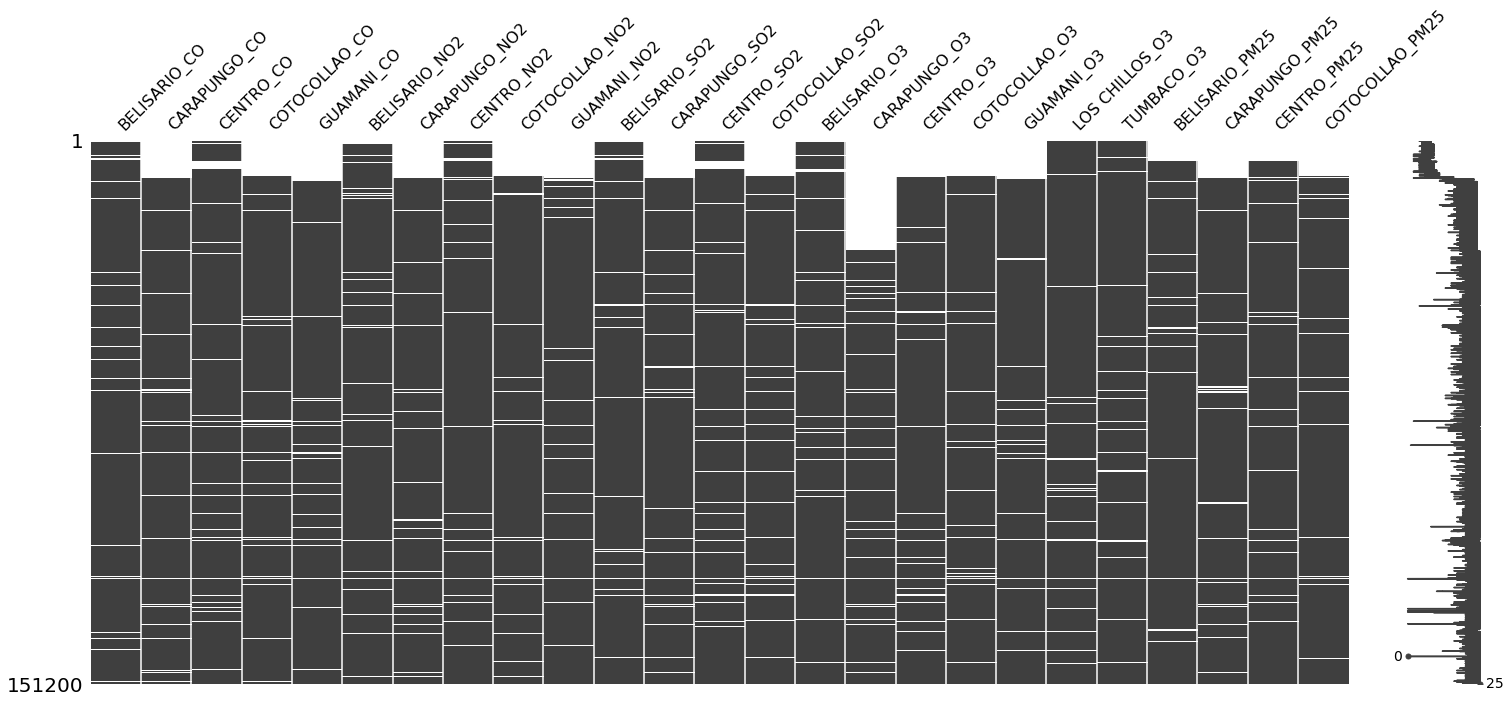

In [18]:
msno.matrix(df)

El problema con los datos nulos se soluciona al tomar estimaciones diarias, semanales o mensuales de los datos.

In [19]:
df.isnull().sum() # Con esto observamos la cantidad de datos nulos que tenemos en el dataset

BELISARIO_CO        6267
CARAPUNGO_CO       16514
CENTRO_CO           8993
COTOCOLLAO_CO      16525
GUAMANI_CO         16818
BELISARIO_NO2       6468
CARAPUNGO_NO2      16010
CENTRO_NO2          7461
COTOCOLLAO_NO2     15515
GUAMANI_NO2        16149
BELISARIO_SO2       6655
CARAPUNGO_SO2      15936
CENTRO_SO2          8657
COTOCOLLAO_SO2     16170
BELISARIO_O3        6740
CARAPUNGO_O3       35485
CENTRO_O3          16583
COTOCOLLAO_O3      15746
GUAMANI_O3         15847
LOS CHILLOS_O3      5432
TUMBACO_O3          6048
BELISARIO_PM25     10640
CARAPUNGO_PM25     14657
CENTRO_PM25        10928
COTOCOLLAO_PM25    15594
dtype: int64

In [20]:
df.head()

BELISARIO_CO  CARAPUNGO_CO  CENTRO_CO  COTOCOLLAO_CO  \
date                                                                        
2004-01-01 00:00:00          7.42           NaN       4.33            NaN   
2004-01-01 01:00:00          7.96           NaN       4.45            NaN   
2004-01-01 02:00:00          8.42           NaN       3.53            NaN   
2004-01-01 03:00:00          9.06           NaN       3.36            NaN   
2004-01-01 04:00:00          6.57           NaN       2.99            NaN   

                     GUAMANI_CO  BELISARIO_NO2  CARAPUNGO_NO2  CENTRO_NO2  \
date                                                                        
2004-01-01 00:00:00         NaN            NaN            NaN      121.37   
2004-01-01 01:00:00         NaN            NaN            NaN       82.82   
2004-01-01 02:00:00         NaN            NaN            NaN       37.27   
2004-01-01 03:00:00         NaN            NaN            NaN       27.22   
2004-01-01 04:00:00         NaN            NaN            NaN       16.72   

                     COTOCOLLAO_NO2  GUAMANI_NO2  ...  CARAPUNGO_O3  \
date                                              ...                 
2004-01-01 00:00:00             NaN          NaN  ...           NaN   
2004-01-01 01:00:00             NaN          NaN  ...           NaN   
2004-01-01 02:00:00             NaN          NaN  ...           NaN   
2004-01-01 03:00:00             NaN          NaN  ...           NaN   
2004-01-01 04:00:00             NaN          NaN  ...           NaN   

                     CENTRO_O3  COTOCOLLAO_O3  GUAMANI_O3  LOS CHILLOS_O3  \
date                                                                        
2004-01-01 00:00:00        NaN            NaN         NaN           27.86   
2004-01-01 01:00:00        NaN            NaN         NaN           23.66   
2004-01-01 02:00:00        NaN            NaN         NaN           21.17   
2004-01-01 03:00:00        NaN            NaN         NaN           10.91   
2004-01-01 04:00:00        NaN            NaN         NaN            9.78   

                     TUMBACO_O3  BELISARIO_PM25  CARAPUNGO_PM25  CENTRO_PM25  \
date                                                                           
2004-01-01 00:00:00        8.54             NaN             NaN          NaN   
2004-01-01 01:00:00        4.52             NaN             NaN          NaN   
2004-01-01 02:00:00        1.47             NaN             NaN          NaN   
2004-01-01 03:00:00        6.10             NaN             NaN          NaN   
2004-01-01 04:00:00        2.27             NaN             NaN          NaN   

                     COTOCOLLAO_PM25  
date                                  
2004-01-01 00:00:00              NaN  
2004-01-01 01:00:00              NaN  
2004-01-01 02:00:00              NaN  
2004-01-01 03:00:00              NaN  
2004-01-01 04:00:00              NaN  

[5 rows x 25 columns]

##### Vamos a imputar valores para rellenar los datos nulos con el método fill forward:

In [21]:
df = df.ffill()

<AxesSubplot:>

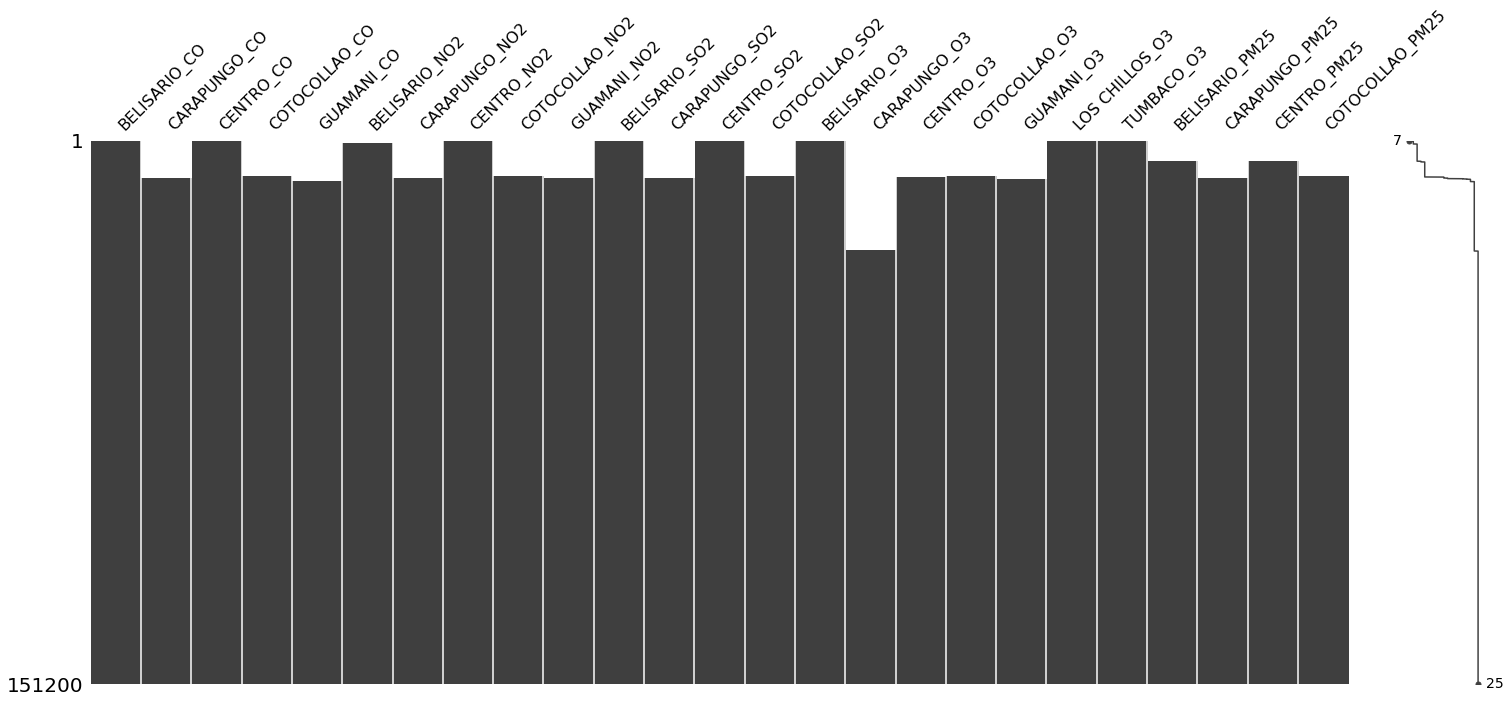

In [22]:
msno.matrix(df)

Text(0.5, 0, 'Año')

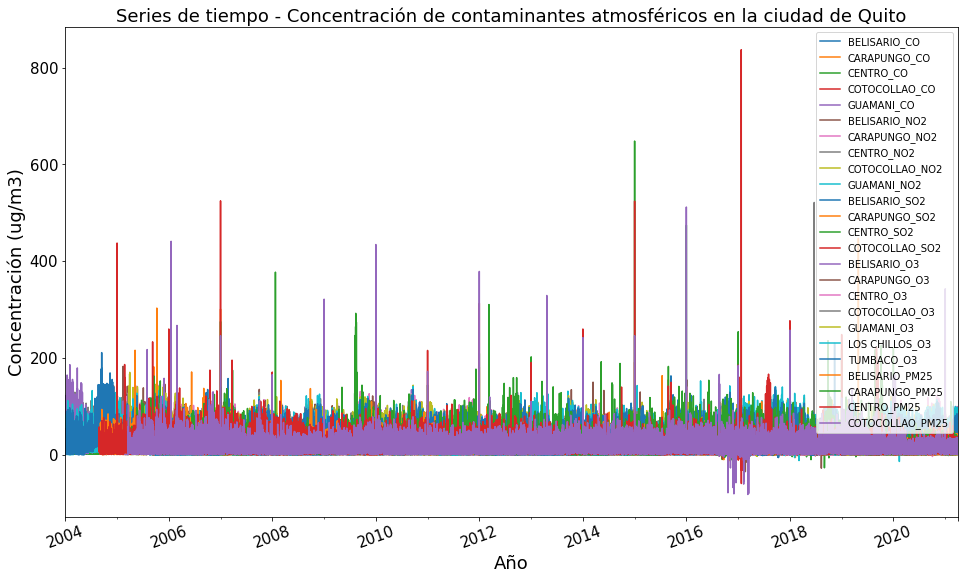

In [23]:
# Series de tiempo para registros de cada hora de cada dia de todos los contaminantes en todas las estaciones. Es ilegible
df.plot(figsize = (16,9), fontsize = 15, rot = 20)
plt.title('Series de tiempo - Concentración de contaminantes atmosféricos en la ciudad de Quito', fontsize=18)
plt.ylabel('Concentración (ug/m3)', fontsize=18)
plt.xlabel('Año', fontsize=18, )

<AxesSubplot:xlabel='date'>

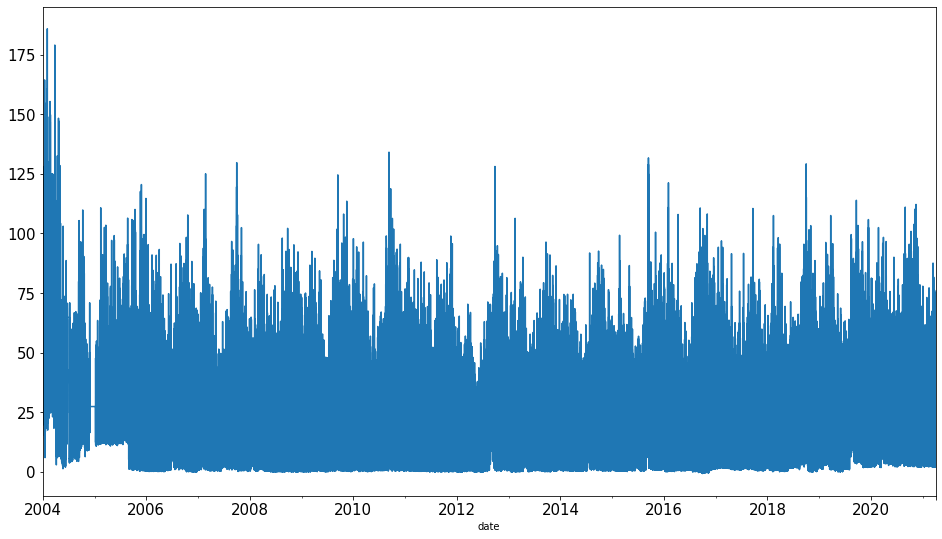

In [24]:
# Series de tiempo para registros de cada hora de cada dia para el contaminante O3 en la estación Belisario. Es ilegible
df['BELISARIO_O3'].plot(figsize = (16,9), fontsize = 15)

En vista que las gráficas anteriores son difíciles de visualizar, vamos a sacar submuestras para poder identificar el
comportamiento de las series de tiempo de mejor manera.

Para ello se crean 3 tipos de datos de conjunto de datos:
* df_dia: Valor promedio por cada dia de registros
* df_semana: Valores promedio por cada semana
* df_mes: Valor promedio por cada mes

Hasta este punto se tienen los datos preparados y se procede a guardarlos para cargarlos cuando sea necesario

In [25]:
df.to_csv('datos_contaminantes_tfm.csv') # de esta manera guardamos nuestro dataframe con los datos preparados a un archivo .csv

In [26]:
df = pd.read_csv("datos_contaminantes_tfm.csv", index_col = 0)  # Importar dataframe

In [27]:
df.index = pd.to_datetime(df.index)  #Transformar el índice del DF a tipo de dato Fecha.

In [28]:
df_dia = df.resample('D').mean()
df_semana = df.resample('W').mean()
df_mes = df.resample('M').mean()

<AxesSubplot:xlabel='date'>

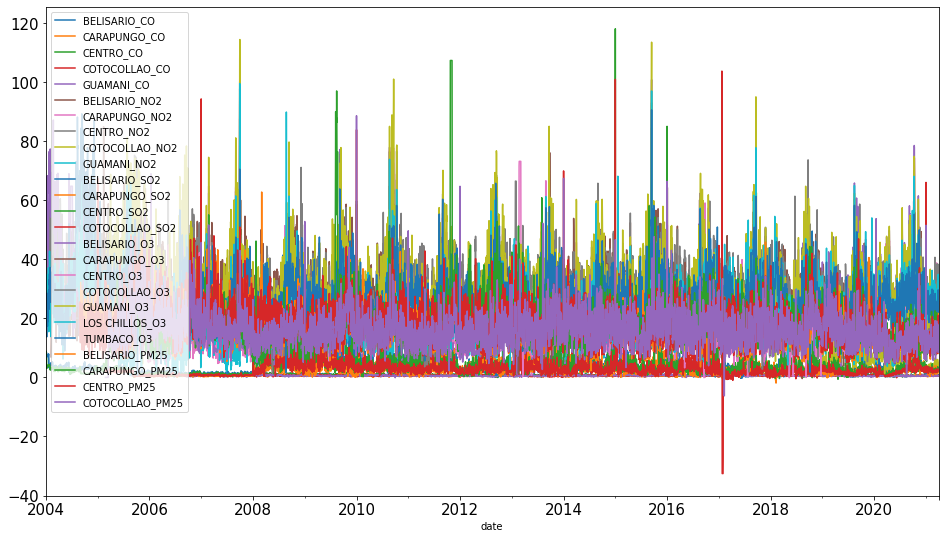

In [29]:
# Series de tiempo para registros diarios en base a la media
df_dia.plot(figsize = (16,9), fontsize = 15)

In [30]:
# Se observa en la gráfica anterior que existen valores de concentración de contaminantes menores que cero, 
# lo cual indica que existe errores en los datos originales, por lo cual se debe corregir esos errores.

In [31]:
df.describe() # Con esto observamos los estadísticos descriptivos de los datos
# y se puede ver que existen valores mínimos en el dataset que son menores que cero, los cuales deberán ser eliminados

BELISARIO_CO   CARAPUNGO_CO      CENTRO_CO  COTOCOLLAO_CO  \
count  151200.000000  140625.000000  151200.000000  141082.000000   
mean        1.063654       0.613049       0.990916       0.676602   
std         0.978484       0.449470       0.761876       0.473247   
min        -0.070000      -0.290000      -0.710000      -1.010000   
25%         0.480000       0.360000       0.520000       0.380000   
50%         0.740000       0.490000       0.760000       0.540000   
75%         1.230000       0.690000       1.170000       0.800000   
max        10.200000      11.900000       9.160000       8.880000   

          GUAMANI_CO  BELISARIO_NO2  CARAPUNGO_NO2     CENTRO_NO2  \
count  139809.000000  150264.000000  140623.000000  151200.000000   
mean        0.640114      27.940878      17.867237      28.626936   
std         0.385005      13.955024      11.947658      14.209027   
min        -0.330000     -35.450000      -4.060000      -0.710000   
25%         0.400000      18.180000       9.080000      18.200000   
50%         0.550000      26.260000      14.710000      27.230000   
75%         0.760000      35.770000      23.910000      36.980000   
max         5.550000     182.340000     102.930000     521.310000   

       COTOCOLLAO_NO2    GUAMANI_NO2  ...   CARAPUNGO_O3      CENTRO_O3  \
count   141082.000000  140544.000000  ...  120491.000000  140793.000000   
mean        19.068696      17.580976  ...      26.044412      23.065622   
std         12.410431      11.763730  ...      18.788738      21.049156   
min         -1.520000     -14.400000  ...      -3.430000      -0.820000   
25%          9.070000       8.360000  ...      11.010000       5.120000   
50%         16.970000      15.250000  ...      22.740000      16.900000   
75%         26.750000      24.620000  ...      38.710000      36.710000   
max        114.090000     155.240000  ...     154.610000     145.680000   

       COTOCOLLAO_O3    GUAMANI_O3  LOS CHILLOS_O3     TUMBACO_O3  \
count  141083.000000  140459.00000   151200.000000  151200.000000   
mean       23.803697      31.36651       24.415122      27.616416   
std        20.214725      21.06419       21.647636      21.940303   
min        -2.170000      -3.77000      -12.520000      -6.260000   
25%         6.440000      14.49000        6.280000       9.370000   
50%        18.880000      28.71000       19.120000      24.080000   
75%        37.160000      45.05000       37.350000      41.080000   
max       137.850000     169.96000      152.230000     210.810000   

       BELISARIO_PM25  CARAPUNGO_PM25    CENTRO_PM25  COTOCOLLAO_PM25  
count   145279.000000   140640.000000  145473.000000    141086.000000  
mean        17.476251       18.714759      18.057695        16.491200  
std         11.619420       14.710398      13.356560        11.743116  
min        -13.530000      -11.330000     -60.010000       -82.670000  
25%          9.450000        9.570000       9.670000         8.940000  
50%         15.460000       16.110000      15.860000        14.330000  
75%         22.870000       24.050000      23.680000        21.330000  
max        447.110000      648.380000     837.340000       511.880000  

[8 rows x 25 columns]

Con la siguiente función vamos a eliminar los datos negativos del dataset

In [32]:
def negativos_a_cero(df):
    if isinstance(df, type(pd.Series(dtype = 'float64'))):
        return df.apply(lambda x: max(0,x))
    else:
        return df.select_dtypes(include = 'number').clip(lower= 0)

In [33]:
df = negativos_a_cero(df) # reasignamos el dataframe al nuevo valor que obtenemos de la función anterior

In [34]:
# Corremos nuevamente los valores diarios, semanales y mensuales con el nuevo dataframe

In [35]:
df_dia = df.resample('D').mean()
df_semana = df.resample('W').mean()
df_mes = df.resample('M').mean()

In [36]:
df.describe() # Se observa que todos los valores mínimos son cero, ya no hay valores negativos

BELISARIO_CO   CARAPUNGO_CO      CENTRO_CO  COTOCOLLAO_CO  \
count  151200.000000  140625.000000  151200.000000  141082.000000   
mean        1.063659       0.613109       0.991148       0.676772   
std         0.978479       0.449377       0.761499       0.472952   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.480000       0.360000       0.520000       0.380000   
50%         0.740000       0.490000       0.760000       0.540000   
75%         1.230000       0.690000       1.170000       0.800000   
max        10.200000      11.900000       9.160000       8.880000   

          GUAMANI_CO  BELISARIO_NO2  CARAPUNGO_NO2     CENTRO_NO2  \
count  139809.000000  150264.000000   140623.00000  151200.000000   
mean        0.640141      27.943102       17.86739      28.626949   
std         0.384952      13.948826       11.94741      14.209002   
min         0.000000       0.000000        0.00000       0.000000   
25%         0.400000      18.180000        9.08000      18.200000   
50%         0.550000      26.260000       14.71000      27.230000   
75%         0.760000      35.770000       23.91000      36.980000   
max         5.550000     182.340000      102.93000     521.310000   

       COTOCOLLAO_NO2    GUAMANI_NO2  ...   CARAPUNGO_O3      CENTRO_O3  \
count   141082.000000  140544.000000  ...  120491.000000  140793.000000   
mean        19.068941      17.581285  ...      26.047182      23.067526   
std         12.410042      11.763108  ...      18.784833      21.047057   
min          0.000000       0.000000  ...       0.000000       0.000000   
25%          9.070000       8.360000  ...      11.010000       5.120000   
50%         16.970000      15.250000  ...      22.740000      16.900000   
75%         26.750000      24.620000  ...      38.710000      36.710000   
max        114.090000     155.240000  ...     154.610000     145.680000   

       COTOCOLLAO_O3     GUAMANI_O3  LOS CHILLOS_O3     TUMBACO_O3  \
count  141083.000000  140459.000000   151200.000000  151200.000000   
mean       23.805178      31.367136       24.415652      27.617484   
std        20.212950      21.063235       21.646972      21.938922   
min         0.000000       0.000000        0.000000       0.000000   
25%         6.440000      14.490000        6.280000       9.370000   
50%        18.880000      28.710000       19.120000      24.080000   
75%        37.160000      45.050000       37.350000      41.080000   
max       137.850000     169.960000      152.230000     210.810000   

       BELISARIO_PM25  CARAPUNGO_PM25    CENTRO_PM25  COTOCOLLAO_PM25  
count   145279.000000   140640.000000  145473.000000    141086.000000  
mean        17.477121       18.715750      18.104689        16.502709  
std         11.617901       14.708959      13.235420        11.700791  
min          0.000000        0.000000       0.000000         0.000000  
25%          9.450000        9.570000       9.670000         8.940000  
50%         15.460000       16.110000      15.860000        14.330000  
75%         22.870000       24.050000      23.680000        21.330000  
max        447.110000      648.380000     837.340000       511.880000  

[8 rows x 25 columns]

<AxesSubplot:xlabel='date'>

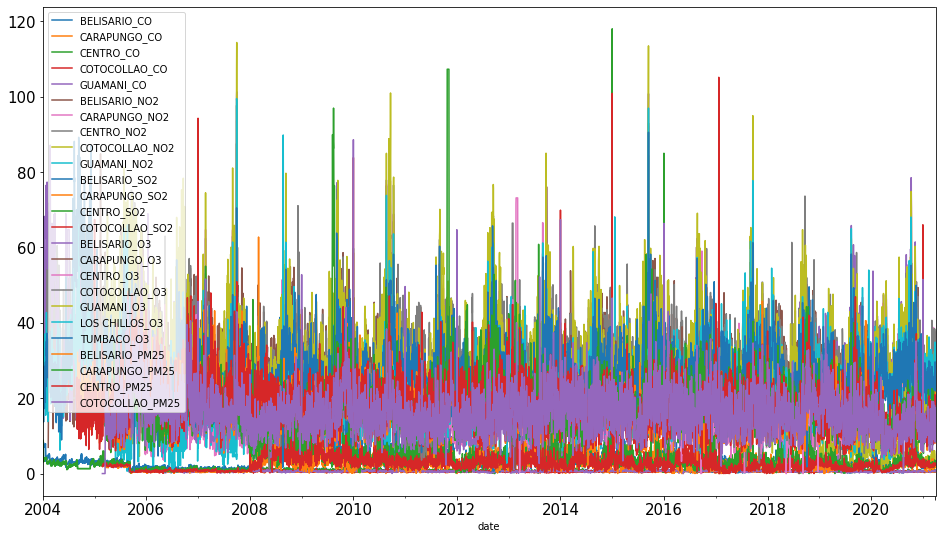

In [37]:
# Se observa que las series de tiempo para registros diarios en base a la media ya no tienen valores negativos

df_dia.plot(figsize = (16,9), fontsize = 15)

<AxesSubplot:xlabel='date'>

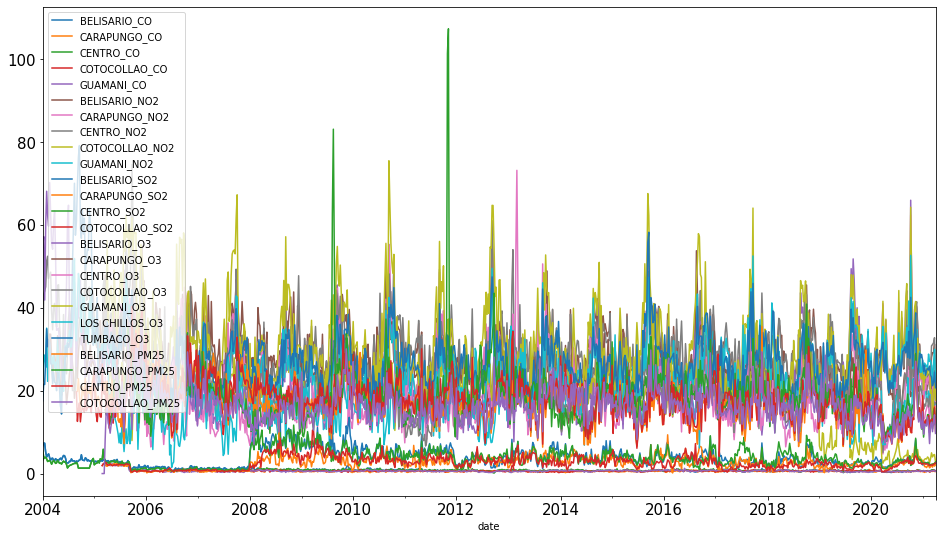

In [38]:
# Series de tiempo para registros semanales en base a la media, donde los patrones de los datos se observan
# de mejor manera que el gráfico anterior que fue realizado por día

df_semana.plot(figsize = (16,9), fontsize = 15)

Text(0.5, 0, 'Año')

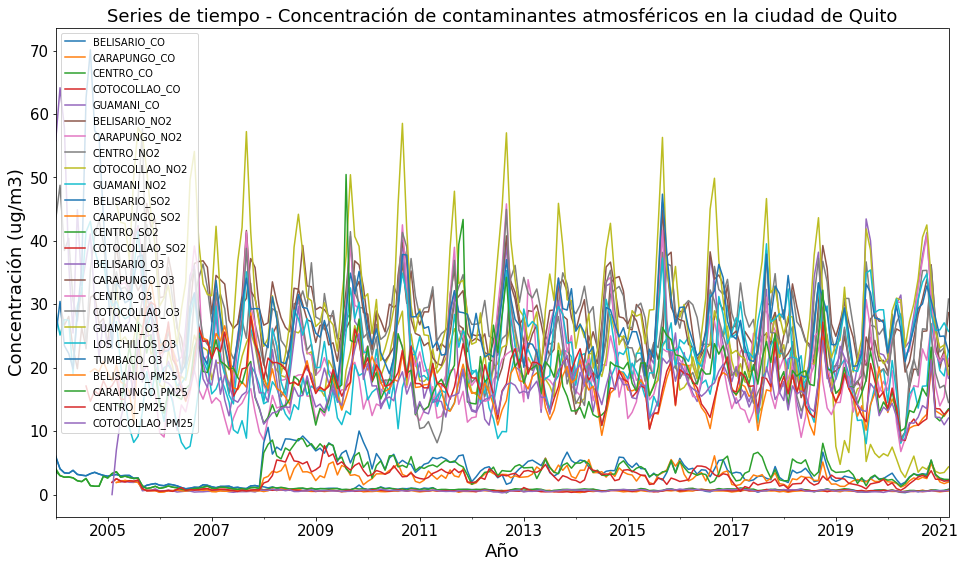

In [39]:
# Series de tiempo para registros mensuales en base a la media, en donde los patrones de los datos se observan
# de mejor manera que los gráficos diarios y semanales. 

df_mes.plot(figsize = (16,9), fontsize = 15)
plt.title('Series de tiempo - Concentración de contaminantes atmosféricos en la ciudad de Quito', fontsize=18)
plt.ylabel('Concentración (ug/m3)', fontsize=18)
plt.xlabel('Año', fontsize=18)

In [40]:
# Realizamos la gráfica solamente el contaminante O3 en la estación de monitoreo Belisario, donde
# se visualiza una aparente estacionalidad de los datos.

<AxesSubplot:xlabel='date'>

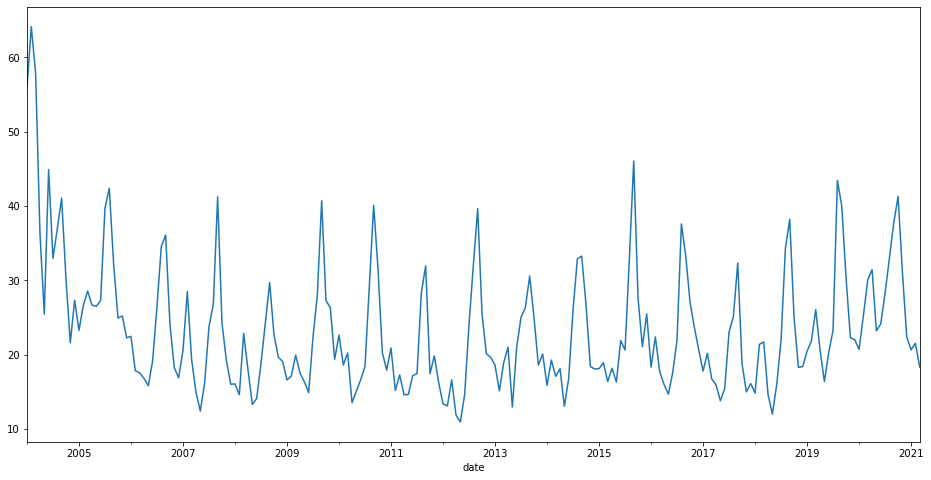

In [41]:
df_mes['BELISARIO_O3'].plot(figsize= (16,8))

## Exploración de datos
[ÍNDICE](#ÍNDICE)

En general, para poder modelar una serie de tiempo, esta deber ser determinística: Los sucesos en la serie, o el evento deben ser generados a partir de sucesos anteriores que repiten las mismas salidas, si se trata del mismo suceso, es decir, no ocurren al azar.

### Curtosis y simetría
[ÍNDICE](#ÍNDICE)

Nos permite conocer la homogeneidad y distribución de los datos.

Función para examinar curtosis y simetria de los datos.

In [42]:
def plot_dist(df):
    
    cols = df.columns[0:]
    n_cols = min(len(cols), 5)
    #n_rows = 8
    n_rows = int(np.ceil(len(cols) / n_cols))
    sn.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
    axes = axes.flatten() 
    #fig.suptitle('Distribuciones')
    df_plot = df
    for col, ax in zip(cols, axes):
        ax=sn.distplot(df_plot[col].dropna(), ax=ax, label = col, axlabel=False,)
    
        ax.legend(loc=2)
#         labels(col, "p", ax)
    return fig



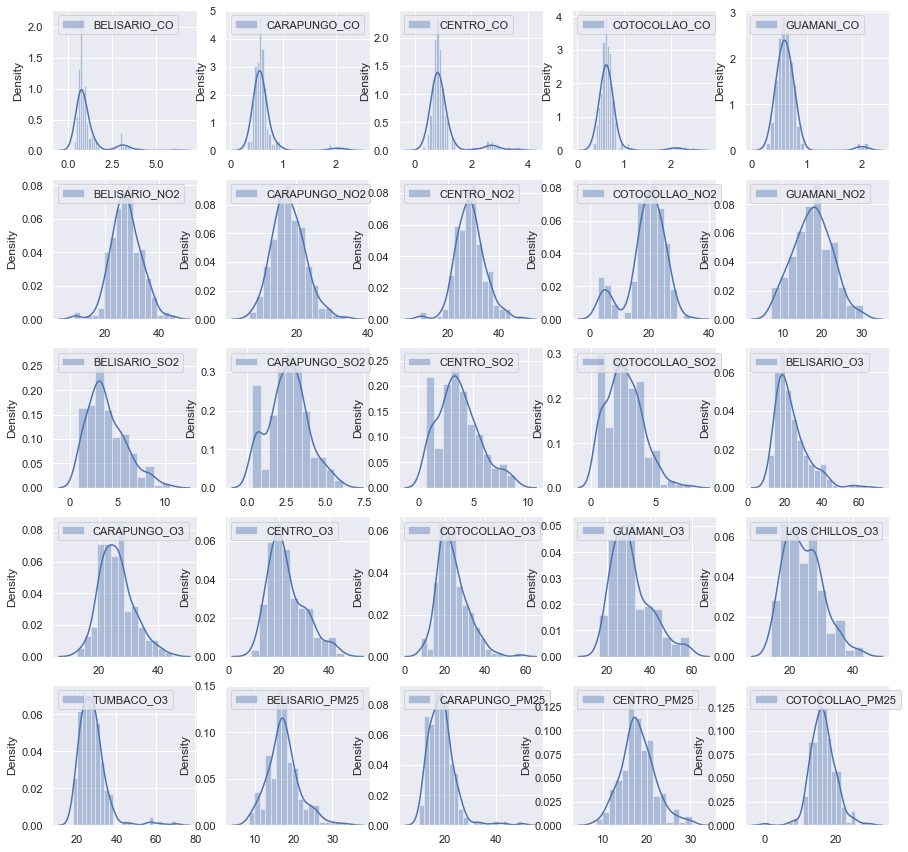

In [43]:
fig=plot_dist(df_mes)

In [44]:
df_mes.dropna().kurt()

BELISARIO_CO       1.631603
CARAPUNGO_CO       2.073374
CENTRO_CO          0.502212
COTOCOLLAO_CO      2.347406
GUAMANI_CO        -0.552059
BELISARIO_NO2      1.015503
CARAPUNGO_NO2      0.415642
CENTRO_NO2         1.580286
COTOCOLLAO_NO2     0.285121
GUAMANI_NO2       -0.247565
BELISARIO_SO2      0.267037
CARAPUNGO_SO2      0.237430
CENTRO_SO2         0.113764
COTOCOLLAO_SO2     0.781623
BELISARIO_O3       0.914082
CARAPUNGO_O3       0.480759
CENTRO_O3          0.842887
COTOCOLLAO_O3      0.534165
GUAMANI_O3         1.095529
LOS CHILLOS_O3    -0.287567
TUMBACO_O3         1.274414
BELISARIO_PM25     0.983254
CARAPUNGO_PM25     9.399445
CENTRO_PM25        0.401085
COTOCOLLAO_PM25    0.266575
dtype: float64

In [45]:
df_mes.dropna().skew()

BELISARIO_CO       0.841627
CARAPUNGO_CO       0.961485
CENTRO_CO         -0.218763
COTOCOLLAO_CO      0.388889
GUAMANI_CO        -0.054145
BELISARIO_NO2     -0.246924
CARAPUNGO_NO2      0.397878
CENTRO_NO2        -0.538468
COTOCOLLAO_NO2    -0.968706
GUAMANI_NO2        0.107328
BELISARIO_SO2      0.784836
CARAPUNGO_SO2      0.348256
CENTRO_SO2         0.579741
COTOCOLLAO_SO2     0.637061
BELISARIO_O3       1.144530
CARAPUNGO_O3       0.615470
CENTRO_O3          0.989301
COTOCOLLAO_O3      0.735788
GUAMANI_O3         1.093843
LOS CHILLOS_O3     0.455406
TUMBACO_O3         0.719584
BELISARIO_PM25     0.282020
CARAPUNGO_PM25     2.276347
CENTRO_PM25        0.046289
COTOCOLLAO_PM25    0.380121
dtype: float64

### Varianza
[ÍNDICE](#ÍNDICE)

Función para graficar las observaciones frente a su predecesor, de este modo se puede analizar la varianza de forma gráfica

In [46]:
df['centro_backshift'] = df.BELISARIO_O3.shift(-1)

In [47]:
def varianza_analizar(df):
    
    cols = df.columns[0:]
    n_cols = min(len(cols), 5)
    #n_rows = 8
    n_rows = int(np.ceil(len(cols) / n_cols))
    sn.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
    axes = axes.flatten() 
    #fig.suptitle('Distribuciones')
    df_plot = df
    for col, ax in zip(cols, axes):
        ax=sn.scatterplot(df_plot[col].dropna(),df_plot[col].dropna().shift(-1) , ax=ax, label = col)
        ax.legend(loc=2)
#         labels(col, "p", ax)
    return fig



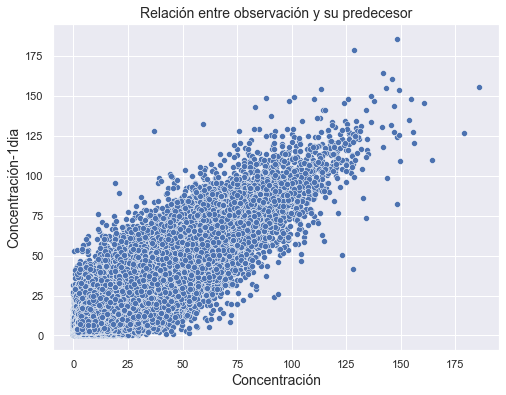

In [48]:
fig = plt.subplots(figsize = (8,6))
sn.scatterplot(df.BELISARIO_O3, df.centro_backshift)
plt.title('Relación entre observación y su predecesor', fontsize= 14)
plt.xlabel('Concentración',fontsize= 14)
plt.ylabel('Concentración-1dia',fontsize= 14)
plt.savefig('Analisis de varianza.png')

Para solucionar el problema de la varianza cambiante en el tiempo, se utiliza una transformación Cox-BoX, PowerTransform

In [49]:
mes = df_mes # vamos a trabajar con un dataframe llamado mes, al cual le asignamos los valores del dataframe df_mes

In [50]:
mes.columns

Index(['BELISARIO_CO', 'CARAPUNGO_CO', 'CENTRO_CO', 'COTOCOLLAO_CO',
       'GUAMANI_CO', 'BELISARIO_NO2', 'CARAPUNGO_NO2', 'CENTRO_NO2',
       'COTOCOLLAO_NO2', 'GUAMANI_NO2', 'BELISARIO_SO2', 'CARAPUNGO_SO2',
       'CENTRO_SO2', 'COTOCOLLAO_SO2', 'BELISARIO_O3', 'CARAPUNGO_O3',
       'CENTRO_O3', 'COTOCOLLAO_O3', 'GUAMANI_O3', 'LOS CHILLOS_O3',
       'TUMBACO_O3', 'BELISARIO_PM25', 'CARAPUNGO_PM25', 'CENTRO_PM25',
       'COTOCOLLAO_PM25'],
      dtype='object')

#### Sacamos el promedio mensual de cada contaminante con los datos que dispongo

In [51]:
mes['promedio_CO'] = (mes['BELISARIO_CO']+ mes['CARAPUNGO_CO'] + mes['CENTRO_CO'] + mes['COTOCOLLAO_CO']+ mes['GUAMANI_CO'])/5

mes['promedio_NO2'] = (mes['BELISARIO_NO2']+ mes['CARAPUNGO_NO2'] + mes['CENTRO_NO2'] + mes['COTOCOLLAO_NO2']+ mes['GUAMANI_NO2'])/5

mes['promedio_SO2'] = (mes['BELISARIO_SO2']+ mes['CARAPUNGO_SO2'] + mes['CENTRO_SO2'] + mes['COTOCOLLAO_SO2'])/4

mes['promedio_O3'] = (mes['BELISARIO_O3']+ mes['CARAPUNGO_O3'] + mes['CENTRO_O3'] + mes['COTOCOLLAO_O3']+ mes['GUAMANI_O3']+ mes['LOS CHILLOS_O3'])/6

mes['promedio_PM25'] = (mes['BELISARIO_PM25']+ mes['CARAPUNGO_PM25'] + mes['CENTRO_PM25'] + mes['COTOCOLLAO_PM25'])/4






In [52]:
# Se renombra las nuevas columnas creadas de promedios mensuales para cada contaminante

mes.rename(columns = {'promedio_CO':'CO','promedio_NO2':'NO2','promedio_SO2':'SO2','promedio_O3':'O3','promedio_PM25':'PM25'}, inplace=True)

In [53]:
mes.columns

Index(['BELISARIO_CO', 'CARAPUNGO_CO', 'CENTRO_CO', 'COTOCOLLAO_CO',
       'GUAMANI_CO', 'BELISARIO_NO2', 'CARAPUNGO_NO2', 'CENTRO_NO2',
       'COTOCOLLAO_NO2', 'GUAMANI_NO2', 'BELISARIO_SO2', 'CARAPUNGO_SO2',
       'CENTRO_SO2', 'COTOCOLLAO_SO2', 'BELISARIO_O3', 'CARAPUNGO_O3',
       'CENTRO_O3', 'COTOCOLLAO_O3', 'GUAMANI_O3', 'LOS CHILLOS_O3',
       'TUMBACO_O3', 'BELISARIO_PM25', 'CARAPUNGO_PM25', 'CENTRO_PM25',
       'COTOCOLLAO_PM25', 'CO', 'NO2', 'SO2', 'O3', 'PM25'],
      dtype='object')

In [54]:
mes['Mes']= mes.index.month

Graficamos la concentración de los contaminantes en base a diagramas de caja y bigotes con los datos mensuales obtenidos 
de todos los años para poder observar la estacionalidad de los mismos

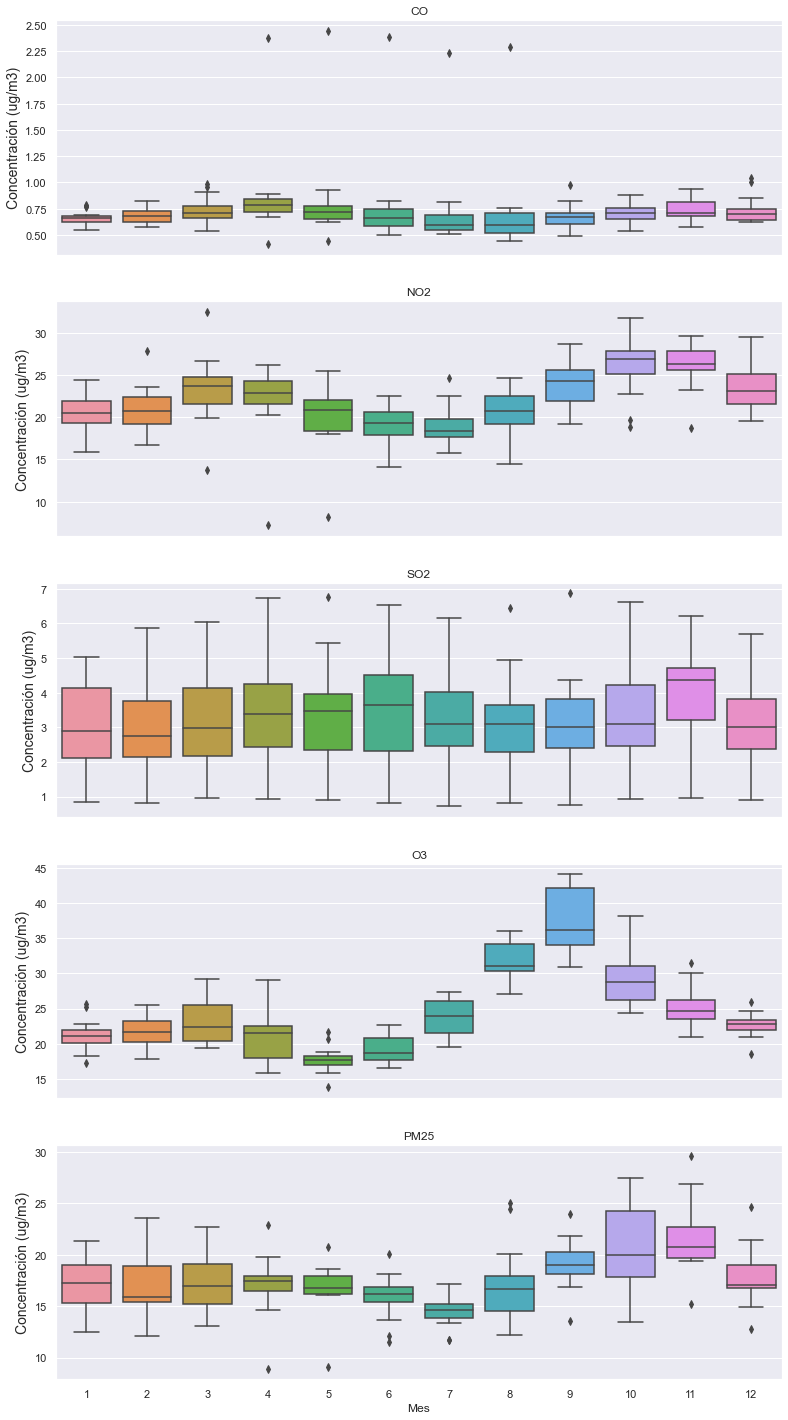

In [55]:
fig, axes = plt.subplots(5, 1, figsize = (13, 25), sharex =True)

for name, ax in zip(['CO','NO2','SO2','O3','PM25'], axes):
    sn.boxplot(data = mes, x='Mes', y=name, ax=ax)
    ax.set_ylabel('Concentración (ug/m3)', fontsize = 14)
    ax.set_title(name)
    
    if ax != axes[-1]:
        ax.set_xlabel('')

# plt.savefig('Concentracion_de_contaminantes_en_Quito.png', bbox_inches = 'tight', dpi=500)

In [56]:
df_mes.drop(columns=['CO','NO2','SO2','O3','PM25','Mes'], inplace=True, axis= 1)

### Análisis de correlación

[ÍNDICE](#ÍNDICE)

In [57]:
correlacion = df_mes.corr()

<AxesSubplot:>

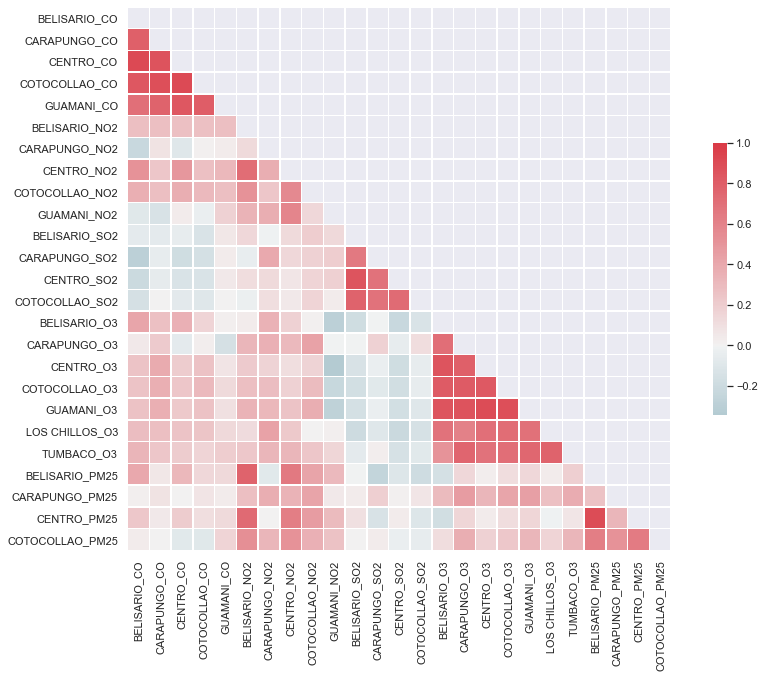

In [58]:
mask = np.triu(np.ones_like(correlacion, dtype = np.bool))

fig, ax = plt.subplots(figsize = (15, 10))
cmap = sn.diverging_palette(220, 10, as_cmap = True)
sn.heatmap(correlacion, mask  = mask, vmax = 1, cmap = cmap, center = 0, linewidths=0.5,square= True, cbar_kws = {"shrink":.5})

## Selección del contaminante
[ÍNDICE](#ÍNDICE)

In [59]:
contaminante = df_mes ['BELISARIO_O3'].dropna()

In [60]:
contaminante1 = df_dia ['BELISARIO_O3'].dropna()

#### Descomponemos la serie

In [61]:
contaminante.describe()

count    207.000000
mean      23.447634
std        8.722005
min       10.939892
25%       17.450444
50%       21.002000
75%       26.921606
max       64.146078
Name: BELISARIO_O3, dtype: float64

<AxesSubplot:xlabel='date'>

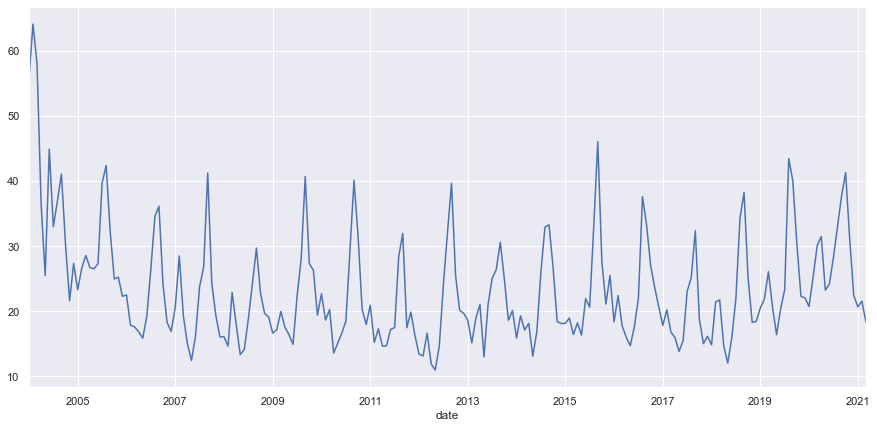

In [62]:
contaminante.plot(figsize = (15,7)) # esta es gráfica de la serie original para el contaminante O3 en la estación Belisario

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [64]:
descomposicion = seasonal_decompose(contaminante)

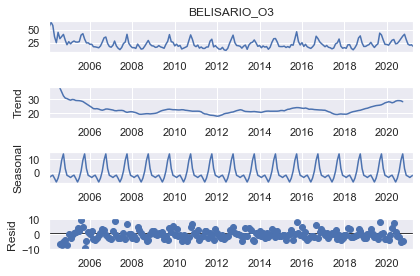

In [65]:
fig = descomposicion.plot()

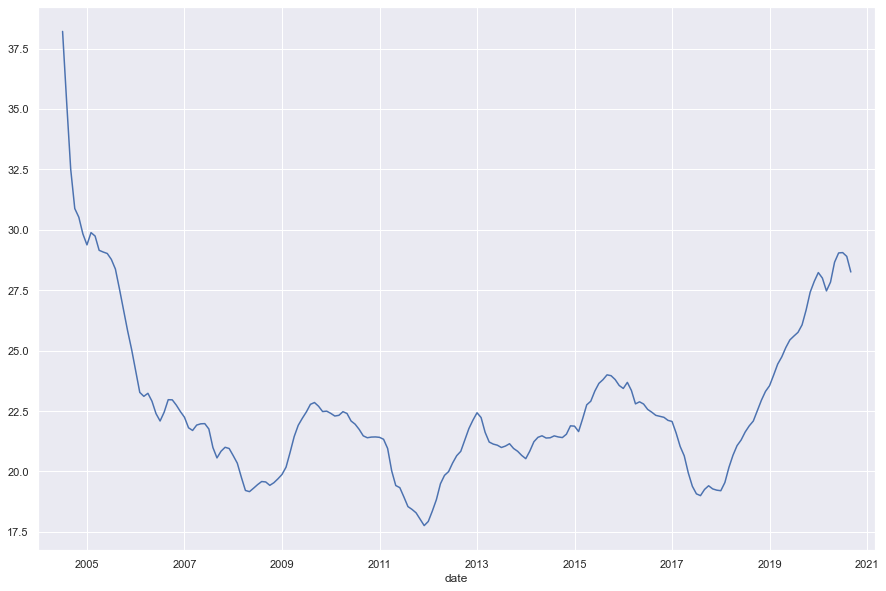

In [66]:
fig = descomposicion.trend.plot(figsize = (15,10))

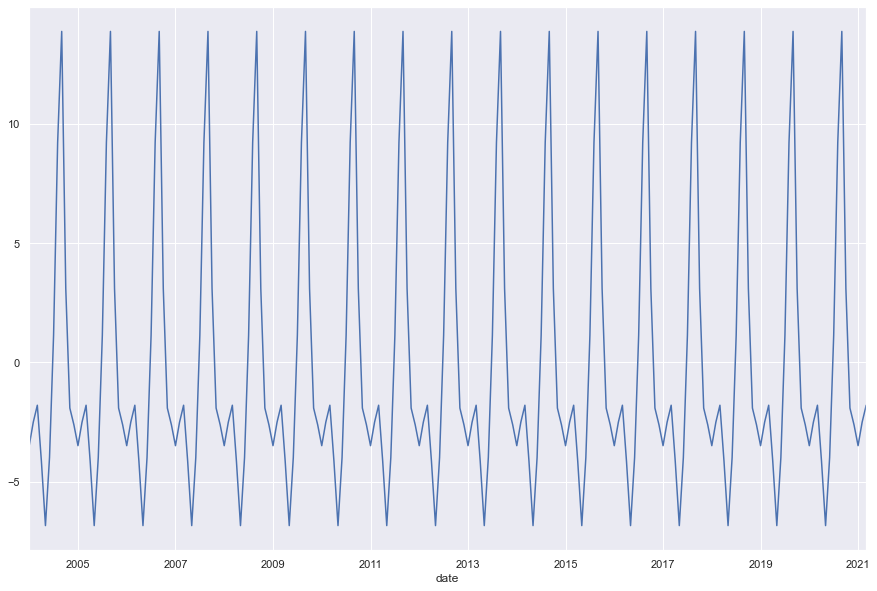

In [67]:
fig = descomposicion.seasonal.plot(figsize = (15,10))

In [68]:
# Vamos a graficar en una misma gráfica los datos originales, la tendencia y el componente estacional

<AxesSubplot:xlabel='date'>

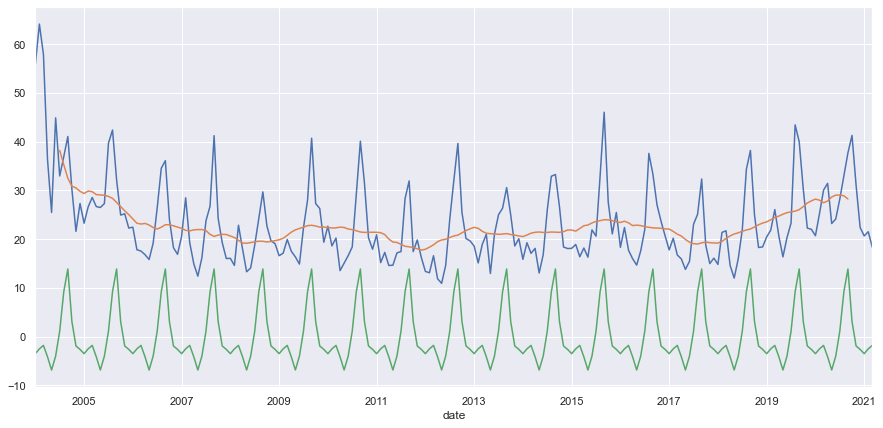

In [69]:
contaminante.plot(figsize = (15,7))  # los datos originales están representados en la línea azul
descomposicion.trend.plot()  # la tendencia está representada por la línea naranja
descomposicion.seasonal.plot()  # el componente estacional está representado en la línea verde

<AxesSubplot:xlabel='date'>

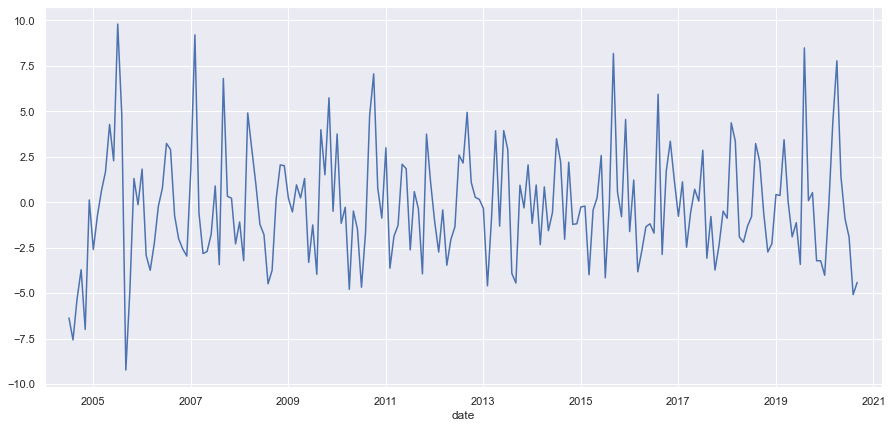

In [70]:
descomposicion.resid.plot(figsize = (15,7))  # con esto se saca los residuos

## Estacionariedad
[ÍNDICE](#ÍNDICE)

Para comprobar si cada serie es estacionaria o no, se lleva a cabo:
- Análisis visual de las gráficas de autocorrelacion.
- Contraste de hipótesis. Prueba de Dickey Fuller aumentada.

In [71]:
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Prueba de Dickey-Fuller aumentada sobre la serie de tiempo de concentración promedio diaria para el ozono troposférico en la estación de Belisario

In [72]:
adfuller(contaminante1)

(-6.8048137611845245,
 2.1904024454841743e-09,
 33,
 6266,
 {'1%': -3.4313940441948807,
  '5%': -2.8620013751563964,
  '10%': -2.567015587023998},
 40278.40926618168)

Prueba de Dickey-Fuller aumentada sobre la serie de tiempo de concentración promedio mensual para el ozono troposférico en la estación de Belisario

In [73]:
adfuller(contaminante)

(-1.9745478517055235,
 0.2978432549381867,
 14,
 192,
 {'1%': -3.4648754262570978,
  '5%': -2.876714157488788,
  '10%': -2.574858699001736},
 1099.2556106562256)

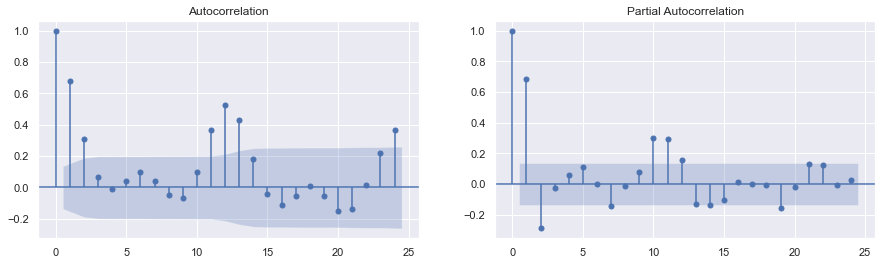

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
plot_acf(contaminante, ax = ax[0])
plot_pacf(contaminante, ax = ax[1]);
#plt.savefig('belisario_autocorrelacion.png', bbox_inches= 'tight')

In [75]:
estacionarios = [[i , adfuller(df_mes[i].dropna())[1] ]for i in df_mes.columns]
estacionarios = pd.DataFrame(estacionarios, columns=['Estación_Contaminante', 'p-value'])

#estacionarios.to_csv('dickey_fuller.csv')

In [76]:
def autocorrelacion(df):
    
    cols = df.columns[0:]
    n_cols = min(len(cols), 5)
    #n_rows = 8
    n_rows = int(np.ceil(len(cols) / n_cols))
    sn.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16,16))
    axes = axes.flatten() 
    #fig.suptitle('Distribuciones')
    df_plot = df
    for col, ax in zip(cols, axes):
        ax=plot_acf(df_plot[col].dropna(), ax=ax,title=  col)
        #ax.legend(loc=2)
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
#         labels(col, "p", ax)
    return fig

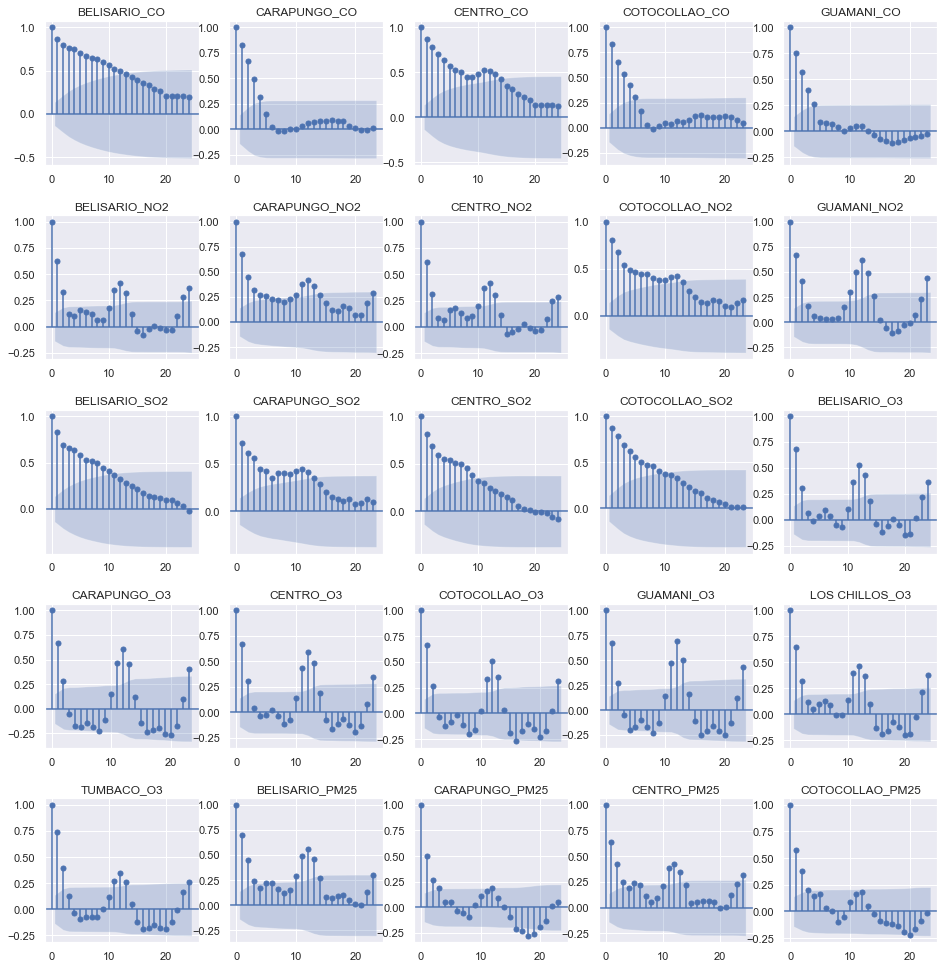

In [77]:
fig = autocorrelacion(df_mes)
#fig.savefig('autocorrelacion.png', bbox_inches='tight')

In [78]:
def autocorrelacion_2(df):
    
    cols = df.columns[0:]
    n_cols = min(len(cols), 5)
    #n_rows = 8
    n_rows = int(np.ceil(len(cols) / n_cols))
    sn.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
    axes = axes.flatten() 
    #fig.suptitle('Distribuciones')
    df_plot = df
    for col, ax in zip(cols, axes):
        ax=plot_pacf(df_plot[col].dropna(), ax=ax, title = col)
        #ax.legend(loc = 3)
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
#         labels(col, "p", ax)
    return fig

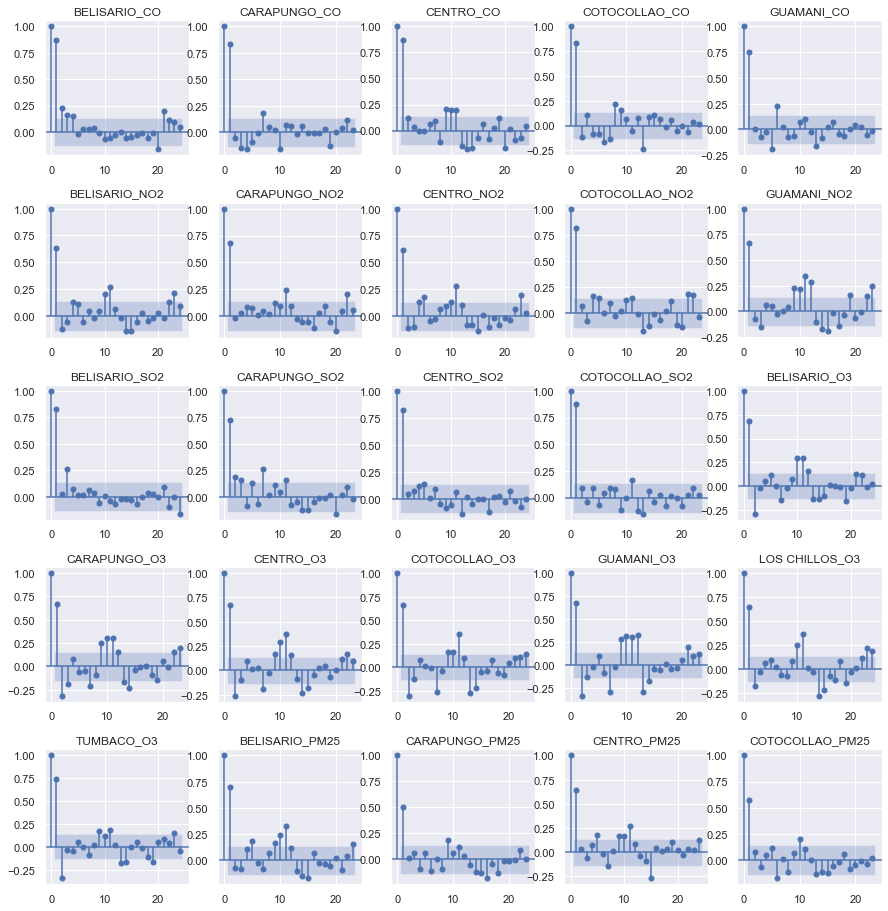

In [79]:
fig = autocorrelacion_2(df_mes)
#fig.savefig('parcialautocorrelacion.png',bbox_inches='tight')

## Construcción del modelo
[ÍNDICE](#ÍNDICE)

### Selección del modelo

Sklearn, está desarrollado para datos que pueden ordenarse de cualquier forma sin afectar el rendimiento del entrenamiento, pero en series temporales, es importante tomar en cuenta el orden en el que son guardados.

EL paquete tradicional de modelado es sklearn, pero en realidad se emplea en este caso una libreria especialmente diseñada para el analisis de series de tiempo o datos que dependen mucho del orden en el fueron registrados

In [80]:
# pip install sktime --->    Instalar sktime

In [81]:
# Librería para definir datos de entrenamiento y datos de validación
from sktime.forecasting.model_selection import temporal_train_test_split 


# Para visualizar las series
from sktime.utils.plotting import plot_series 


# Ayuda a definir el horizonte de predicciones, es decir 
# en entrenamiento, toma los indices del conjunto de validación 
# para comparar los valores predichos de los reales

# en predicción ayuda a definir hasta cuantos valores se van a predecir
from sktime.forecasting.base import ForecastingHorizon





from sktime.forecasting.hcrystalball import HCrystalBallForecaster

In [82]:
y_train, y_test = temporal_train_test_split(contaminante)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='BELISARIO_O3'>)

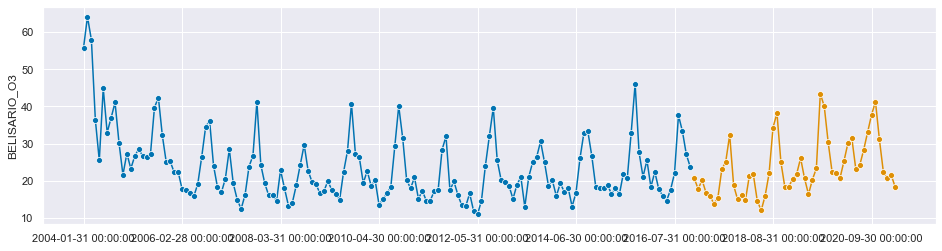

In [83]:
plot_series(y_train, y_test)

In [84]:
# MÉTRICAS
from sktime.performance_metrics.forecasting import mean_absolute_error  # MAE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error # MAPE
from sktime.performance_metrics.forecasting import mean_squared_error  # RMSE

In [85]:
def metricas(y_test, y_pred):
    print("MAE: %f" % (mean_absolute_error(y_test,y_pred)))
    print("RMSE: %f"%(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("MAPE: %f"%(mean_absolute_percentage_error(y_test,y_pred)))   

### Suavizado Exponencial Simple

[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

`TethaForecaster`equivale a trabajar con un suavisado exponencial simple.

In [86]:
from sktime.forecasting.theta import ThetaForecaster # Suavizado exponencial simple

In [87]:
df_mes['COTOCOLLAO_PM25'].describe()

count    194.000000
mean      16.434004
std        3.521198
min        0.000000
25%       14.276603
50%       16.182331
75%       18.194553
max       29.600694
Name: COTOCOLLAO_PM25, dtype: float64

In [88]:
#df_mes.loc[(df_mes['COTOCOLLAO_PM25'] == 0),'COTOCOLLAO_PM25']=16.434004

In [89]:
y_train.describe()

count    155.000000
mean      23.416221
std        9.091098
min       10.939892
25%       17.232885
50%       20.562110
75%       26.921606
max       64.146078
Name: BELISARIO_O3, dtype: float64

In [90]:

fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range("2017-01",
                                 periods=len(y_test),
                                 freq="M")), is_relative=False)

#fh = ForecastingHorizon(pd.date_range("2017-01", periods = len(y_test), freq='M'), is_relative=False)


forecaster = ThetaForecaster(sp=12)

y_train.index = pd.PeriodIndex(y_train.index)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

y_test.index = pd.PeriodIndex(y_test.index)

In [91]:
metricas(y_test, y_pred)

MAE: 5.496577
RMSE: 7.150455
MAPE: 0.226872


Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

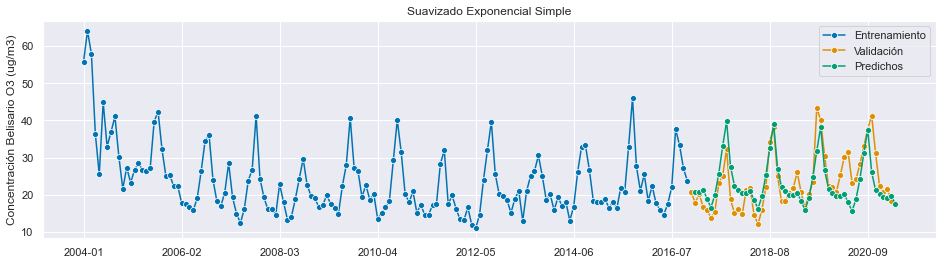

In [92]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación','Predichos'])
plt.title('Suavizado Exponencial Simple')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
# plt.savefig('resultado_Belisario_O3_SES', bbox_inches = 'tight')

### Predictor Ingenuo

[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [105]:
# Predictor ingenuo
from sktime.forecasting.naive import NaiveForecaster

In [106]:
# Para busqueda de parametros
from sktime.forecasting.model_selection import SlidingWindowSplitter,ExpandingWindowSplitter # desarrollo de la validación cruzada
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [107]:
fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range("2017-01", periods = len(y_test), freq='M')), is_relative=False)

In [108]:
#Validación cruzada.  Grid search
#cv = SlidingWindowSplitter(initial_window=12)
cv = ExpandingWindowSplitter(start_with_window=True,initial_window=12, fh=7)

forecaster = NaiveForecaster()

param_grid = {"strategy":["last", "mean", "drift"], "sp":range(1,12,1)}

gscv = ForecastingGridSearchCV(forecaster = forecaster, param_grid= param_grid, cv=cv)


In [109]:
#Emplear datos con el modelo ajustado para entrenarlo
gscv.fit(y_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=7, initial_window=None),
                        forecaster=NaiveForecaster(),
                        param_grid={'sp': range(1, 12),
                                    'strategy': ['last', 'mean', 'drift']})

In [110]:
#Predecir según el horizonte
y_pred = gscv.predict(fh)

Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

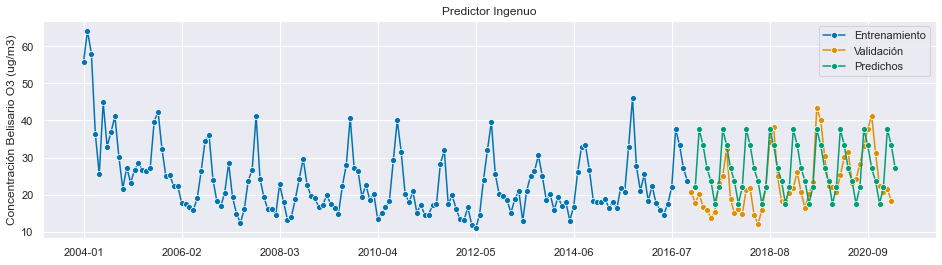

In [111]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación', 'Predichos'])
plt.title('Predictor Ingenuo')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#  plt.savefig('resultado_cotocollao_so2_nf', bbox_inches = 'tight')

In [118]:
gscv.best_params_

{'sp': 6, 'strategy': 'last'}

In [119]:
forecaster.fit(y_train)

NaiveForecaster()

In [120]:
y_pred = forecaster.predict(fh)

In [121]:

metricas(y_test,y_pred)

MAE: 5.944979
RMSE: 7.523812
MAPE: 0.248023


Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

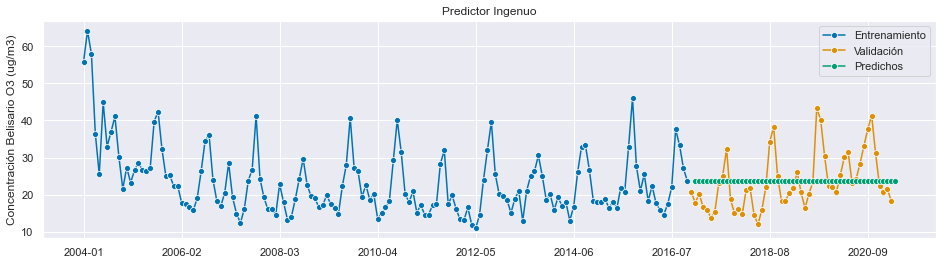

In [122]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación', 'Predichos'])
plt.title('Predictor Ingenuo')
plt.ylabel('Concentración Belisario O3 (ug/m3)')


### SARIMA

[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [123]:
#ARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA

In [124]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ARIMA(order=(0,1,1), seasonal_order=(1,0,1,12))
#forecaster = ThetaForecaster(sp = 12)


In [125]:
forecaster.fit(y_train)

ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 1, 12))

In [126]:
y_pred = forecaster.predict(fh)

In [127]:
metricas(y_test, y_pred)

MAE: 4.400800
RMSE: 5.682024
MAPE: 0.191325


Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

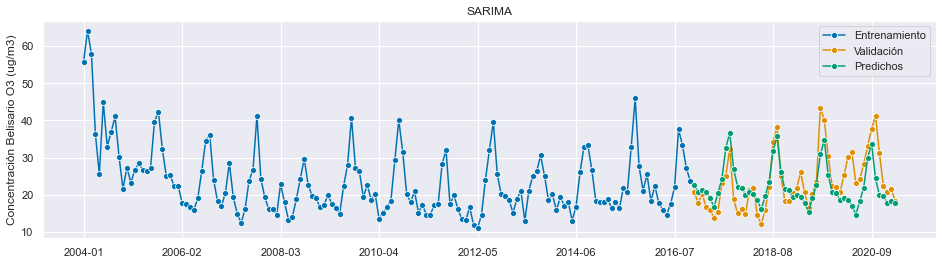

In [128]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación','Predichos'])
plt.title('SARIMA')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#plt.savefig('resultado_Belisario_O3_SARIMA', bbox_inches = 'tight')

In [129]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  155
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -468.346
Date:                            Tue, 26 Oct 2021   AIC                            946.693
Time:                                    23:54:31   BIC                            961.877
Sample:                                         0   HQIC                           952.861
                                            - 155                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0044      0.015     -0.282      0.778      -0.035       0.026
ma.L1         -0.4154      0.061     -6.804      0.000      -0.535      -0.296
ar.S.L12       0.9858      0.019     51.228      0.000       0.948       1.024
ma.S.L12      -0.8041      0.121     -6.672      0.000      -1.040      -0.568
sigma2        22.8611      2.932      7.798      0.000      17.115      28.607
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 6.44
Prob(Q):                              0.67   Prob(JB):                         0.04
Heteroskedasticity (H):               0.33   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
import pmdarima as pm

In [131]:
stepwise_fit = pm.auto_arima(y_train, start_p=0, start_q=0,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1,
                             #D=1,
                             max_P=2,max_D=2, max_Q=3, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1005.613, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1027.871, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=983.164, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1002.839, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1026.019, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1029.827, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=968.924, Time=0.65 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=955.423, Time=0.64 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=953.707, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1004.925, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=955.373, Time=0.68 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=996.146, Time=0.34 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept 

In [132]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  155
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -467.037
Date:                              Tue, 26 Oct 2021   AIC                            944.074
Time:                                      23:55:28   BIC                            959.258
Sample:                                           0   HQIC                           950.242
                                              - 155                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3547      0.073     -4.886      0.000      -0.497      -0.212
ma.L2         -0.1562      0.065     -2.420      0.016      -0.283      -0.030
ar.S.L12       0.9801      0.024     41.541      0.000       0.934       1.026
ma.S.L12      -0.7825      0.119     -6.559      0.000      -1.016      -0.549
sigma2        22.8122      2.686      8.492      0.000      17.547      28.077
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.08
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

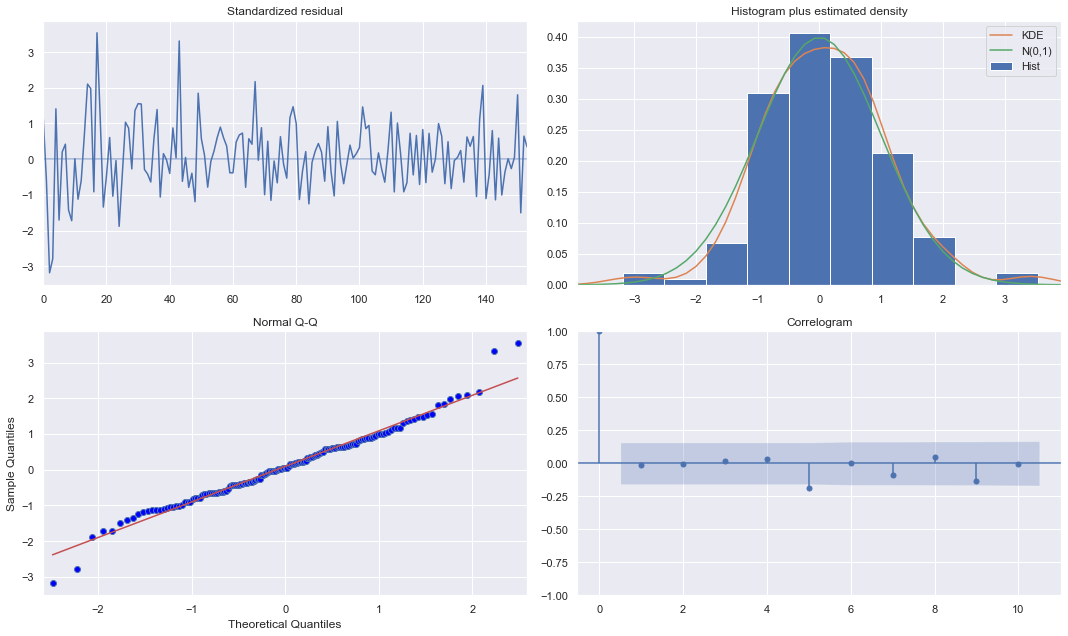

In [133]:
stepwise_fit.plot_diagnostics(figsize=(15,9));
plt.tight_layout();
#plt.savefig('grafica de diagnostico.png', bbox_inches = 'tight')

Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

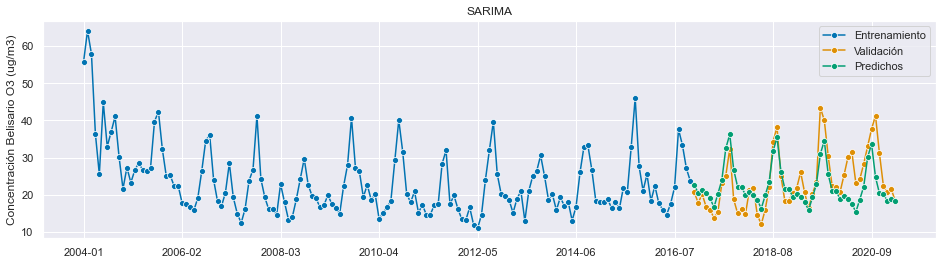

In [134]:
# Vamos a modelar con el mejor modelo obtenido:

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ARIMA(order=(0,1,2), seasonal_order=(1,0,1,12))
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación','Predichos'])
plt.title('SARIMA')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#plt.savefig('resultado_Belisario_O3_SARIMA', bbox_inches = 'tight')

In [135]:

# from sklearn.neighbors import KNeighborsRegressor

### Regresión de Bosques Aleatorios


[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [136]:
from sktime.forecasting.compose import ReducedForecaster

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

In [137]:
regressor = RandomForestRegressor(n_estimators=250)

In [138]:
forecaster = ReducedForecaster(estimator=regressor, strategy='recursive')

In [139]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=250))

In [140]:
y_pred = forecaster.predict(fh)

In [141]:
metricas(y_test, y_pred)

MAE: 7.031432
RMSE: 9.240484
MAPE: 0.290249


Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

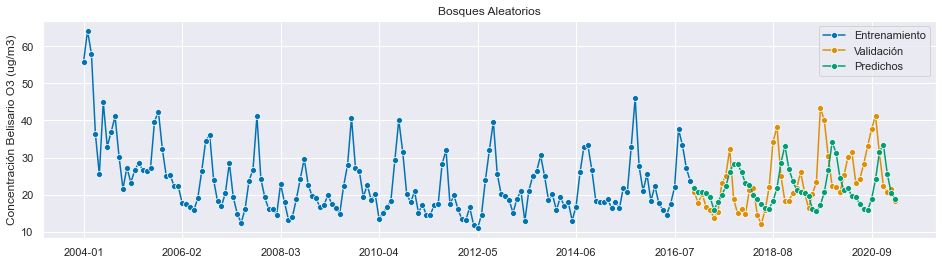

In [142]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación','Predichos'])
plt.title('Bosques Aleatorios')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#plt.savefig('resultado_Belisario_O3_RF', bbox_inches = 'tight')


### Regresión de Soporte Vectorial


[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [143]:
from sklearn.svm import SVR

In [144]:
regressor = SVR(kernel='poly')

In [145]:
forecaster = ReducedForecaster(estimator=regressor, strategy='recursive')

In [146]:
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=SVR(kernel='poly'))

In [147]:
y_pred = forecaster.predict(fh)

In [148]:
metricas(y_test, y_pred)

MAE: 5.482212
RMSE: 7.320396
MAPE: 0.224540


Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

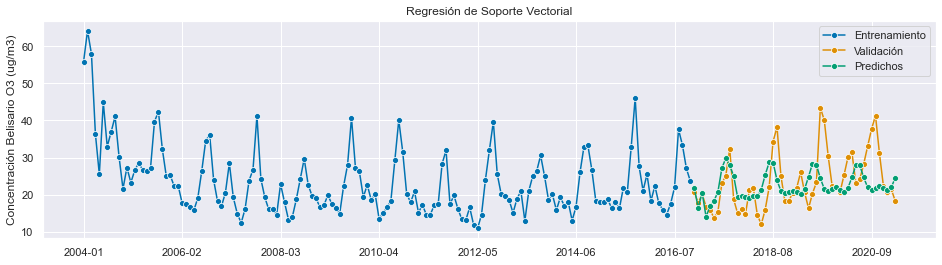

In [149]:
plot_series(y_train,y_test,y_pred, labels=['Entrenamiento', 'Validación','Predichos'])
plt.title('Regresión de Soporte Vectorial')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#plt.savefig('resultado_Belisario_O3_SVR', bbox_inches = 'tight')

### Regresión de Gradiente Ascendente


[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [150]:
from sklearn.ensemble import GradientBoostingRegressor

Text(0, 0.5, 'Concentración Belisario O3 (ug/m3)')

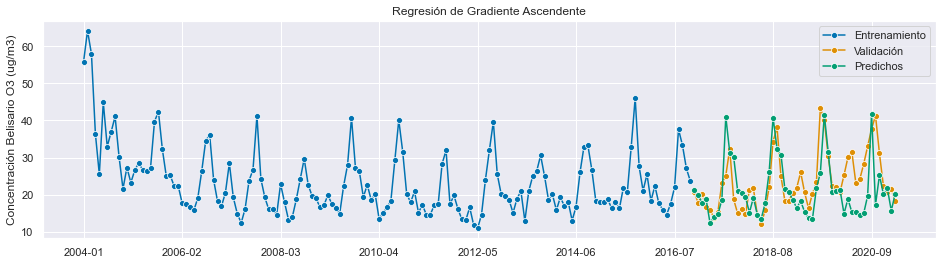

In [151]:
regressor = GradientBoostingRegressor(learning_rate=0.9)
forecaster = ReducedForecaster(regressor, window_length=50, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['Entrenamiento', 'Validación','Predichos']);
mean_absolute_error(y_test, y_pred)
plt.title('Regresión de Gradiente Ascendente')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
#plt.savefig('Belisario_O3_GBR', bbox_inches = 'tight')

In [152]:
metricas(y_test, y_pred)

MAE: 5.403664
RMSE: 7.425300
MAPE: 0.234979


In [153]:
regressor = GradientBoostingRegressor(learning_rate=0.9)
forecaster = ReducedForecaster(regressor, window_length=50, strategy="recursive")

y_train.index = pd.PeriodIndex(y_train.index)
forecaster.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(learning_rate=0.9),
                                     window_length=50)

In [154]:
fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range("2021-04",
                                 periods=45,
                                 freq="M")), is_relative=False)

In [155]:

y_pred = forecaster.predict(fh)

Text(0.5, 0, '')

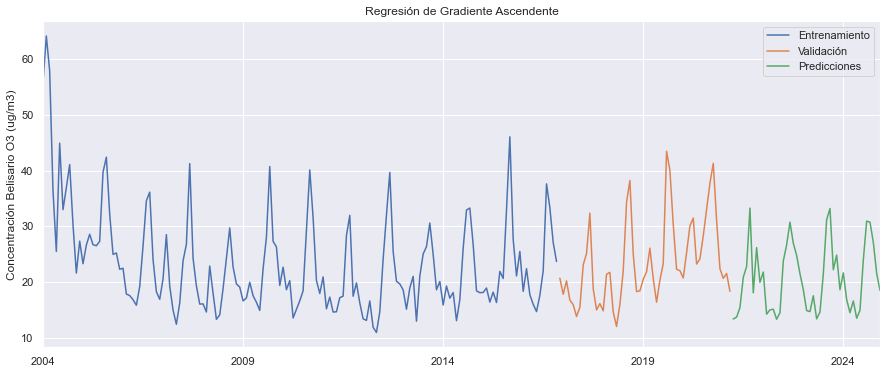

In [156]:
y_train.plot(figsize= (15,6), legend = 'Entrenamiento' )
y_test.plot()
y_pred.plot()
plt.legend(['Entrenamiento', 'Validación', 'Predicciones'])
plt.title('Regresión de Gradiente Ascendente')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
plt.xlabel('')
#plt.savefig('Belisario_O3_GBR.png', bbox_inches = 'tight', dpi = 300)

### Ejemplo de Predicción SARIMA (0,1,2) (1,0,1)

[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)

In [157]:
forecaster = ARIMA(order=(0,1,2), seasonal_order=(1,0,1,12))

In [158]:
y_train.index = pd.PeriodIndex(y_train.index)

In [159]:
forecaster.fit(y_train)

ARIMA(order=(0, 1, 2), seasonal_order=(1, 0, 1, 12))

In [160]:
y_pred = forecaster.predict(fh)

Text(0.5, 0, '')

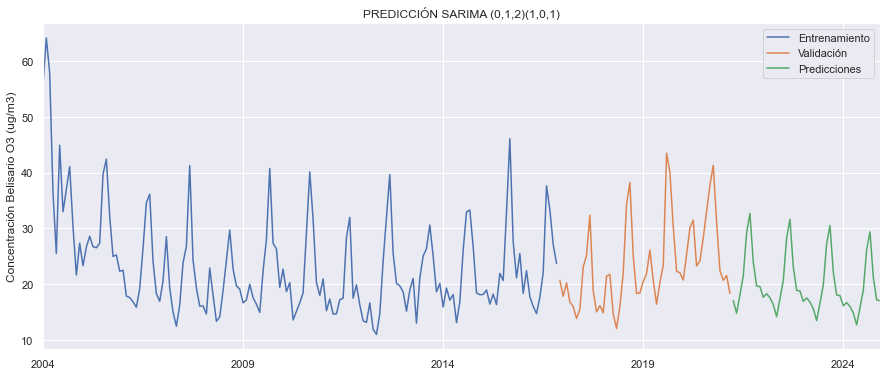

In [161]:
y_train.plot(figsize= (15,6))
y_test.plot()
y_pred.plot()
plt.legend(['Entrenamiento', 'Validación', 'Predicciones'])
plt.title('PREDICCIÓN SARIMA (0,1,2)(1,0,1)')
plt.ylabel('Concentración Belisario O3 (ug/m3)')
plt.xlabel('')
#plt.savefig('Belisario_O3_SARIMA.png', bbox_inches = 'tight', dpi = 500)


[Selección del contaminante](#Selección-del-contaminante)

[ÍNDICE](#ÍNDICE)